# SVM Implementation From Scratch
    Implement the Support vector machien algorithm from scratch based on hinge cost function

## Requierement Packages

In [3]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Implementations:
* hinge loss function
* SVM loss function
* indicator function
* SVM loss gradient function
* Stochastic Gradient Descent
* Batch Gradient Descent
* Cross-validation


In [51]:
path_datests = './datasets'
path_Q4_data = '{data}/Question 3/'.format(data = path_datests)

def read_csv_datasets(train_data_name, test_data_name):
    train_data = pd.read_csv(path_Q4_data + train_data_name)
    train_data['intercept'] = 1
    test_data = pd.read_csv(path_Q4_data + test_data_name)
    test_data['intercept'] = 1
    return [train_data, test_data]

# loss function implementation
def hinge_loss_function(W, X, Y):
    return (1 / X.shape[0]) * np.sum([max(0, 1 - Y[i] * np.dot(X[i], W)) for i in range(X.shape[0])])

def SVM_loss_function(W, X, Y, la):
    return (la * np.sum(W**2) +  hinge_loss_function(W, X, Y))

# gradient of loss function implementation
def indicator_function(W, x, y):
    if(0 >= 1 - y*(np.dot(x, W))):
        return 0
    else:
        return (-1)

def SVM_loss_gradient_function(W, X, Y, la):
    
    if (type(Y) == np.int32):
        Y_batch = np.array([Y])
        X_batch = np.array([X])
        N  = X_batch.shape[0]
    else:
        Y_batch = Y
        X_batch = X
        N  = X_batch.shape[0]
        
    hinge_gradient = []
    if(N == 1):
        hinge_gradient = indicator_function(W, X_batch[0], Y_batch[0]) * X_batch[0] * Y_batch[0]
    else:
        hinge_gradient = np.sum([indicator_function(W, X_batch[i], Y_batch[i]) * X_batch[i] * Y_batch[i]  for i in range(N)], axis=0)
    
    return (2 * la * W + 1/N * hinge_gradient )
   
# implementation of BGD & SGD (with mini-batch)
def GD(X, Y, max_epochs = 100, mini_batch_size = 100, learning_rate = 0.01, hyperparameter = 0.1, method = 'SGD', decreasing_LR = False):
    
    W = np.random.normal(loc = 0, scale = 0.1, size = X.shape[1])
    nth = 0
    for epoch in range(0, max_epochs + 1):
        lr = learning_rate
        X_, Y_ = shuffle(X, Y, n_samples = mini_batch_size)
        for i in range(X_.shape[0]):
            if(method == 'SGD'):
                ascent = SVM_loss_gradient_function(W, X_[i], Y_[i], la = hyperparameter)
            elif(method  == 'BGD'):
                ascent = SVM_loss_gradient_function(W, X_, Y_, la = hyperparameter)
            
            W = W - (lr * ascent)
            if(decreasing_LR):
                lr = lr / (i+1)
    return W

# One VS. All SVM Classifier

def train_SVM_OvA_multipleclass(train_data, epochs_for_every_GD = 100, learning_rate = 1e-4, hyperparameter = 1e-4, method = 'SGD',  decreasing_LR = False):
    labels = [0,1,2,3,4,5,6,7,8,9]
    features = np.array(train_data.drop(columns = ['label']) )
    Ws = []
    for i in labels:
        labels = np.where(train_data['label'] == i, 1 , -1)
        W = GD(features, labels, max_epochs = epochs_for_every_GD, mini_batch_size = 100,
               learning_rate = learning_rate, hyperparameter = hyperparameter, method = method,  decreasing_LR = False)
        
        Ws.append(W)
    return np.array(Ws)

# predict & calcukate accuracy
def predict_a_test_data(weights, test_data):
    labels = [0,1,2,3,4,5,6,7,8,9]
    result = list(np.matmul(weights, test_data))
    prediction = result.index(max(result))
    return labels[prediction]

def predict_test_set(weights, test_data):
    preds = []
    labels = [0,1,2,3,4,5,6,7,8,9]
    for row in test_data.itertuples():
        d = np.array(test_data[2:])
        preds.append(predict_a_test_data(weights, d))
    return np.array(preds)

def calc_model_accuracy(predictions, test_lables):
    return (sum(predictions == test_lables) / len(predictions)) 

# split dataset to folds for cross-validation
def cross_validation_split(data, num_folds = 5):
    folds_size = (data.shape[0] // num_folds)
    folds = []
    for i in range(num_folds):
        validation = data.iloc[range((i*folds_size),((i+1)*folds_size))].reset_index()
        train = data.drop(range((i*folds_size),((i+1)*folds_size))).reset_index()
        folds.append((train, validation))
    return folds

# Cross-validation to choose best lambda (hyperparameter)
def SVM_with_cross_validation_for_choose_lambda(train_data, epochs_for_every_GD = 100, learning_rate = 1e-4, hyperparameter = 1e-10, method = 'SGD', num_folds = 5):
    
    folds = cross_validation_split(train_data, num_folds = num_folds)
    mean_accuracy = 0
    for train, validation in folds:
        weights = train_SVM_OvA_multipleclass(train,epochs_for_every_GD  = epochs_for_every_GD,
                                   learning_rate = learning_rate, hyperparameter = hyperparameter, method = 'SGD')
        
        predictions = predict_test_set(weights, validation)
        
        mean_accuracy += (calc_model_accuracy(predictions, validation['label']) / num_folds)
        
    return mean_accuracy

def show_data(mean_image):
    mean_image = np.array(mean_image)
    plt.figure(figsize=(2,2))
    plt.imshow(mean_image.reshape((28,28)).astype('uint8')) # visualize the mean image
    plt.show()

# MNIST Data Loading

In [5]:
# import datasets
train_data, test_data = read_csv_datasets('mnist_train.csv','mnist_test.csv')

print('Train data shape: ', train_data.shape)
print('Train labels shape: ', train_data['label'].shape)
print('Test data shape: ', test_data.shape)
print('Test labels shape: ', test_data['label'].shape)

Train data shape:  (60000, 786)
Train labels shape:  (60000,)
Test data shape:  (10000, 786)
Test labels shape:  (10000,)


Data label is : 5


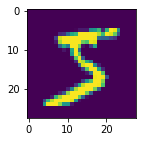

Data label is : 0


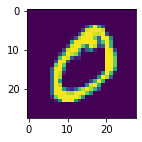

Data label is : 4


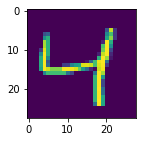

In [48]:
for i, row in train_data.head(3).iterrows():
    print("Data label is : {label}".format(label = row['label']))
    show_data(row[1:-1])

# Choose best hyperparameter using cross-validation

In [ ]:
lambdas = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1]
accuracies = []
for la in lambdas:
    accuracy = SVM_with_cross_validation_for_choose_lambda(train_data, epochs_for_every_GD = 100, learning_rate = 1e-4,
                              hyperparameter = la, method = 'SGD', num_folds = 5)
    accuracies.append(accuracy)
plt.plot(np.log10(lambdas), accuracies, linestyle='-',marker='o')

# SVM Classifier using Stochastic & Batch Gradient Descent

In [ ]:
# Stochastic Gradient Descent
best_lambda = 1e-4

weights = train_SVM_OvA_multipleclass(train_data, epochs_for_every_GD = 100, learning_rate = 1e-4,
                            hyperparameter = best_lambda, method = 'SGD')
predictions = predict_test_set(weights, test_data)
print("accuracy on test dataset: {}".format(calc_model_accuracy(predictions, test_data['label'])))


In [ ]:
# Stochastic Batch Gradient Descent
best_lambda = 1e-4

weights = train_SVM_OvA_multipleclass(train_data, epochs_for_every_GD = 100, learning_rate = 1e-4,
                            hyperparameter = best_lambda, method = 'BGD')
predictions = predict_test_set(weights, test_data)
print("accuracy on test dataset: {}".format(calc_model_accuracy(predictions, test_data['label'])))


# Choose Best Epoch-Size

In [ ]:
# Choose best Epoch 
best_lambda = 1e-4
epochs = [1, 50, 100, 500, 1000, 5000, 10000]
accuracies = []
for epoch in epochs:
    weights = train_SVM_OvA_multipleclass(train_data, epochs_for_every_GD = epoch, learning_rate = 1e-4,
                              hyperparameter = best_lambda, method = 'SGD')
    preds = predict_test_set(weights, test_data)
    accuracies.append(calc_model_accuracy(preds, test_data['label']))
    
plt.plot(np.log10(epochs), accuracies, linestyle='-',marker='o' )
plt.show()
plt.plot((epochs), accuracies, linestyle='-',marker='o' )
plt.show()

In [ ]:
best_lambda = 1e-4
epochs = [1, 50, 100, 500, 1000, 5000, 10000]
accuracies = []
for epoch in epochs:
    weights = train_SVM_OvA_multipleclass(train_data, epochs_for_every_GD = epoch, learning_rate = 1e-4,
                              hyperparameter = best_lambda, method = 'SGD', decreasing_LR=True)
    preds = predict_test_set(weights, test_data)
    accuracies.append(calc_model_accuracy(preds, test_data['label']))
    
plt.plot(np.log10(epochs), accuracies, linestyle='-',marker='o' )
plt.show()
plt.plot((epochs), accuracies, linestyle='-',marker='o' )
plt.show()

# Test the SVM Classifier